# Modeling Change in English Language from 1470-Present

By Helen Liang (hl973), Undergraduate Student, Class of 2021

## Introduction
In this project, we are modeling the change in how the same English word is used across the Early Modern English period and beyond. This project was inspired by and builds upon the [EarlyPrint Lab project](https://earlyprint.org/lab/) by Anupam Basu and Joseph Loewenstein, with Douglas Knox, John Ladd, and Stephen Pentecost.

English is an unstable language, with spellings, usage, and word frequencies changing quickly over short periods of time. Even within the same time period, there are many variations of the same word due to inconsistent spelling. Because of the instability of English, we are interested in seeing how the meaning of words change over time. To find and visualize the shifts in how a particular word is used, we will be using word embeddings. Word embeddings is a technique in which words are represented as vectors, and words that are similar have close vectors. 

There is relatively more stability in Early Modern English than Old or Middle English, hence the choice of Early Modern English texts. Our early modern corpus is [Early English Books Online (EEBO TCP)](https://quod.lib.umich.edu/e/eebogroup/), a collection of English books from 1475 to 1700 that covers a wide range of subjects including politics, sciences, and the arts. 

In [1]:
import sys
import os
from glob import glob
from pathlib import Path
import regex
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import numpy as np
import math
import pickle
from collections import Counter
from nltk.corpus import stopwords

In [2]:
def read_files(directory):
    f_names = []
    for root, _, files in os.walk(directory):
        for file in files:
            f_names.append(os.path.join(root, file))
    return f_names

## Preprocessing

To preprocess the text, we must first strip punctuation. A modified strip_punct.py script was run on all_text_v1_v2.txt 
(all of the EEBO text in one file) to create all_text_v1_v2_nopunct.txt, a clean version of all_text_v1_v2.txt with all non-words removed. A demo of strip punctuation is shown below. 

In [8]:
def strip_punct(filename):
    token_pattern = regex.compile("(\w[\w\'\-]*\w|\w)")
    c = 0
    with open(filename) as reader:
        for line in reader:
            line = line.lower().replace("∣", "")
            tokens = token_pattern.findall(line)
            c += 1
            if c < 4: 
                print(" ".join(tokens))
            

In [5]:
# An example of cleaned text
strip_punct('balanced_txt/000/A00268.headed.txt')

10376 99847128 12146
articles to be enquired off within the prouince of yorke in the metropoliticall visitation of the most reuerend father in go edwin archbishoppe of yorke primate of england and metropolitane in the xix and xx yeare of the raigne of our most gratious souereigne lady elizabeth by the grace of god of england fraunce and ireland queene defendor of the fayth c 1577 1578 imprinted at london by william seres
articles to be enqvired off within the prouince of yorke in the metropoliticall visitation of the most reuerend father in god edwin archbishoppe of yorke primate of england and metropolitane in the xix yeare of the raigne of our most gratious soueraigne lady elizabath by the grace of god of england fraunce and ireland queene defendour of the faith c first whether commō praier be sayd in your church or chappel vpon the sundaies holy dayes at conuenient houres reuerently distinctly and in such order without any kinde of alteration as is appoynted by the booke of commō 

Next, we extract the dates of each text from its XML version. Each date is written out in the date_txt/all directory as a txt file containing the date as one line. The name of the txt file is the same name as the xml file. 

In [7]:
ALL_DIR = 'date_txt/all/'
def extract_year(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if not file.endswith('.xml'):
                continue
            f_name = (os.path.join(root, file))
            with open(f_name, 'r') as f:
                line = f.readline()
                while line and '<date>' not in line: 
                    line = f.readline() 
                searcher = re.search('(?<=<date>)[0-9]+(?=.*<\/date>)', line) # match the first date that occurs between the tags <date> </date>
                if not searcher:
                    print(f_name)
                year = searcher.group(0)
                century = year[:2] + "00"
                path = os.path.join('date_txt', century)
                os.makedirs(path, exist_ok = True) 
            with open(os.path.join(path, Path(file).stem + ".txt"), 'w') as f:
                f.write(year)
            os.makedirs(ALL_DIR, exist_ok = True)
            with open(os.path.join(ALL_DIR, Path(file).stem + ".txt"), 'w') as f:
                f.write(year)

An example of a date file is A89519.txt (parsed from A89519.xml). The date is read in as the first (and only) line. A demo is shown below. 

In [7]:
with open('date_txt/all/A89519.txt') as reader:
    print(reader.read())

1651


In [8]:
# REDEFINED strip_punct for cleaning txt files in balanced_txt directory and outputting 
# each cleaned file separately in the no_punct directory
def strip_punct(directory):
    token_pattern = regex.compile("(\w[\w\'\-]*\w|\w)")
    print(directory)
    for f_name in glob(directory + "*.txt"):
        with open(f_name, 'r') as reader:
            os.makedirs('no_punct', exist_ok = True) 
            with open(os.path.join('no_punct', os.path.basename(f_name)), 'a+') as writer: 
                for line in reader: 
                    line = line.lower().replace("∣", "")
                    tokens = token_pattern.findall(line)
                    writer.write(" ".join(tokens) + "\n")

In [14]:
# To run this cell, uncomment. 
# strip_punct('balanced_txt/**/')

## Nearest Words

[Fasttext](https://pypi.org/project/fasttext/) is an open-source library developed by Facebook AI that generates word embeddings given an input corpus. Fasttext provides two models: cbow and skipgram. Cbow, also known as continuous-bag-of-words, uses the sequence of nearby words to predict the target word. Skipgram sums up the nearby words' vectors to predict the target word. The two models are described in more detail in [Fasttext's official documentation.](https://fasttext.cc/docs/en/unsupervised-tutorial.html) After trying both Cbow and Skipgram, Cbow gave a better ranking of nearby words for EEBO. Therefore, this project uses Fasttext Cbow's word vectors.

The .vec file outputted is the human readable version of word embeddings. Tokenization has already been done by fasttext. 
The nearest function below normalizes and performs dot product on all vectors with the input word vector to find the top 20 nearest words.

Run this cell to find the 20 nearest words of "true". 

In [9]:
output = !python nearest.py embeddings/sgns_v1_v2_d100_1.vec true

In [9]:
# Return a Python list of the top nearest words
def clean_output(output):
    return [re.sub('[\.0-9]+', '', s.replace('\t', '')) for s in output]

In [10]:
def read_vec_file(name):
    words_dict = dict()
    with open(name, "r") as file:
        for i, line in enumerate(file): 
            if i != 0: 
                line = line.strip().split(' ')
                words_dict[line[0]] = [float(n) for n in line[1:]]
        return words_dict
words_dict = read_vec_file('embeddings/sgns_v1_v2_d100_1.vec')

In [11]:
# Find nearest function from nearest.py
def find_nearest(input_word, embeddings, vocab):
    query_id = vocab.index(input_word)
    print(np.sqrt(np.sum(embeddings ** 2, axis=1)))
    normalizer = 1.0 / np.sqrt(np.sum(embeddings ** 2, axis=1))
    embeddings *= normalizer[:, np.newaxis]
    scores = np.dot(embeddings, embeddings[query_id,:])
    sorted_list = sorted(list(zip(scores, vocab)), reverse=True)
    
    nearest = []
    for score, word in sorted_list[0:20]:
        print("{:.3f}\t{}".format(score, word))
        nearest.append(word)

    return nearest

words_dict is a dictionary representation of the .vec file returned by read_vec_file. Words from the corpus are keys and their respective vector representations are values. This will be later used to visualize embeddings.

In [13]:
for k, v in words_dict.items():
    print(k)
    print(v)
    break

the
[-0.18489848, 0.06808506, 0.25595662, 0.17188543, 0.037654955, 0.0051366338, -0.04474668, -0.043178707, 0.04380905, -0.3671004, 0.15313336, -0.13872255, -0.49349466, 0.1728954, 0.18529195, 0.038108274, 0.20786463, 0.15146597, -0.044726238, 0.049716745, -0.26126888, -0.10828109, -0.04244245, 0.01174636, 0.04659954, 0.26178488, 0.08462093, -0.03321066, -0.020420447, -0.24766025, -0.050465543, -0.28281528, 0.13968821, -0.3628608, 0.07868071, 0.068998545, -0.056997843, 0.19090831, -0.15597442, 0.1672764, 0.20952386, -0.100779526, -0.08410791, 0.009130444, 0.17206787, -0.05249392, -0.14769125, -0.2557637, -0.14989932, -0.055034913, -0.27376437, 0.17862496, 0.06681945, -0.15870348, 0.055367753, -0.21392596, -0.24123484, 0.29547364, 0.22669992, 0.17882921, -0.22640234, -0.30965278, 0.16120891, 0.048422385, 0.05698442, 0.17416024, 0.13867001, -0.17245133, 0.11170741, -0.020344907, 0.06829954, 0.043494076, -0.08843164, -0.11732712, -0.2400157, 0.049039885, 0.06697231, 0.24299929, 0.3211362,

## Visualizing EEBO Word Embeddings
To visualize the EEBO word embeddings of each input word and its top 20 neighbors, we used Principal Component Analysis (PCA) to reduce the number of dimensions of each vector down to 2 so each vector may be graphed. 

In the following graphs, the green number indicates the ranking of a neighbor word of how close it is to the input word according to nearest.py. The physical distance of a neighbor word to the input word is closeness determined by PCA's dimensionality reduction. The input words we will be looking at are 'true' and 'awe'.  

| Word   | Modern Meaning   | Expected EME Meaning
|--------|------------------|------------------
|true    | True (not False) |True/just/righteous
|awe     | awe/fear/terror  |awesome/amazing


The embeddings graph was created following the tutorial [“Visualization of Word Embedding Vectors using Gensim and PCA” by Saket Thavanani](https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354). 

In [3]:
def visualize_embeddings(nearest_words, target_word, words_dict, title='Word Embedding Space'): 
    vectors = [words_dict[w] for w in nearest_words]
    two_dim = PCA(random_state=0).fit_transform(vectors)[:,:2]
    x_length = abs(max(two_dim[:,0]) - min(two_dim[:,0]))
    print(x_length)
    y_length = abs(max(two_dim[:,1]) - min(two_dim[:,1]))
    print(y_length)
    plt.figure(figsize=(13,7))
    plt.scatter(two_dim[:,0],two_dim[:,1],linewidths=10,color='blue')
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title(title,size=20)
    for i, word in enumerate(nearest_words):
        if word == target_word:
            c = 'red'
        else:
            c = 'black'
        plt.annotate(word,xy=(two_dim[i,0]+0.02*x_length,two_dim[i,1]-0.015*y_length), color=c)
        
        plt.annotate(i,xy=(two_dim[i,0]+0.01*x_length,two_dim[i,1]-0.05*y_length), color = 'green')
    plt.annotate('', color='red', xy=two_dim[0], xytext=(two_dim[0,0]+0.1*x_length, two_dim[0,1]+0.1*x_length),
        arrowprops=dict(facecolor='red', shrink=0.05))

In [7]:
def execute_graph_embeddings(word, vector_file, output, date):
    output = clean_output(output)
    words_dict = read_vec_file(vector_file)
    visualize_embeddings(output, word, words_dict, title=f'Word Embedding for "{word}" {date}')

3.1341537391016048
2.6460360288361002


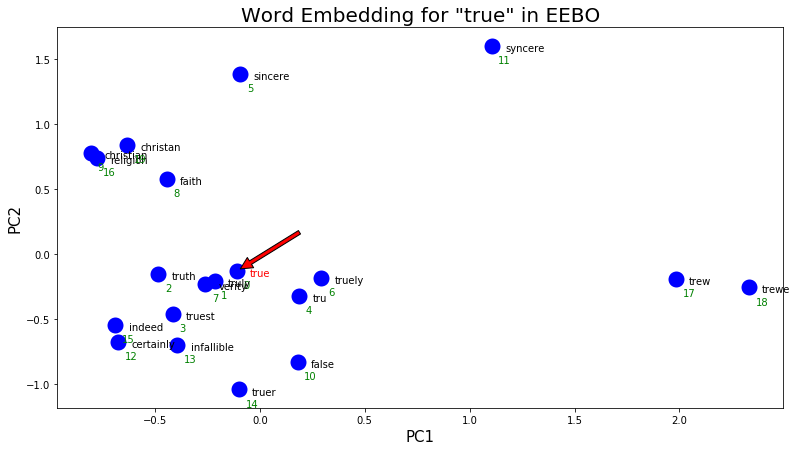

In [71]:
output_true = !python nearest.py embeddings/sgns_v1_v2_d100_1.vec true
execute_graph_embeddings('true', 'embeddings/sgns_v1_v2_d100_1.vec', output_true, 'in EEBO')

Some notable observations for 'true' in EEBO and PCA: 

1. The word embeddings visualized above capture synonyms, alternate spellings, and co-occurrence. An example of a synonym is "truth" or "sincere". An example of alternate spelling is "trew" or "tru". An example of co-occurrence is christian and and certainly (i.e. true christian or certainly true)

2. PCA and nearest neighbors have different similarity rankings. For example, the word "verity" is the 7th nearest word to true using dot product but after reducing vector dimensions down to 2, it is roughly the 2nd closest word. The PCA graph therefore is not a perfect visualization of the nearest words. 

3. Some clusters of words with similar meanings are revealed in this graph. The religious cluster on the top left with words such as faith and religion. There there "truth" and "verity" cluster on bottom left. "certainly" and "indeed" are synonyms and form the cluster meaning agreement on the bottom left. 

3.417725795343853
3.601340399733183


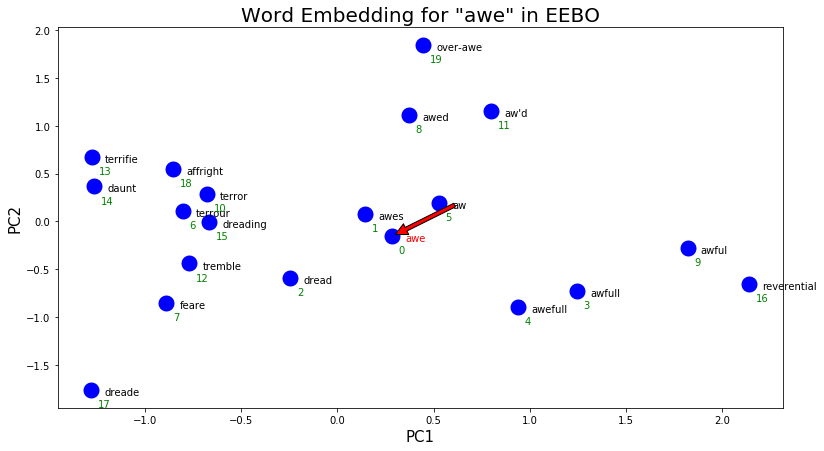

In [72]:
output_awe = !python nearest.py embeddings/sgns_v1_v2_d100_1.vec awe
execute_graph_embeddings('awe', 'embeddings/sgns_v1_v2_d100_1.vec', output_awe, 'in EEBO')

Some notable clusters 'awe' in EEBO: 

1. Fear/terror as a synonym. The words "dreading", "feare", "tremble" in the bottom left corner form this definition. 

2. Awful/bad as a synonym. The cluster of various spellings of 'awful' in the bottom right form this cluster. 

3. Reverential as a synonym. Despite being ranked as 16 (out of 20) and located in the far bottom right corner, 'reverential' could be an emerging definition for 'awe' that is more similar to the way we use 'awe' positively today. 

## Pre/Post Formation of the Royal Society

The Royal Society, the UK's national academy of sciences, was formed in 1660. This could lead to a shift towards more scientific senses of words. To analyze the change in word embeddings, we will regenerate the word vectors with Fasttext using only pre-1660 and post-1660 texts. 


Fasttext will only take one single file as an input. Therefore, first we need to concatenate all pre-1660 and post-1660 texts into two large txt files, pre1660.txt and post1660.txt. This cell will take ~3 minutes to run. 

In [24]:
skipped = 0
pre = 0
post = 0
if os.path.isfile('pre1660.txt'):
    os.remove('pre1660.txt')
if os.path.isfile('post1660.txt'):
    os.remove('post1660.txt')
for file in glob("no_punct/*.txt"):
    name = (Path(file).stem).split('.')[0]
    # Find the corresponding date file and read the year
    date_file = os.path.join('date_txt', 'all', name + '.txt')
    if os.path.isfile(date_file):
        with open(date_file, 'r') as reader:
            year = int(reader.readline())
        if year < 1660:
            write_file = 'pre1660.txt'
            pre += 1
        else:
            write_file = 'post1660.txt'
            post += 1
        with open(write_file, 'a+') as writer: 
            with open(file, 'r') as reader:
                for line in reader:
                    writer.write(line)
    else:
        skipped += 1
print(f'Number texts skipped due to not being able to find a date from xml: {skipped} out of {len(glob("no_punct/*.txt"))}')
print(f'Number of Pre-1660 Texts {pre}')
print(f'Number of Post-1660 Texts {post}')

Number texts skipped due to not being able to find a date from xml: 11561 out of 19946
Number of Pre-1660 Texts 4330
Number of Post-1660 Texts 4055


11.430988758357127
14.632903289126197
12.022654903721623
13.245121212359058


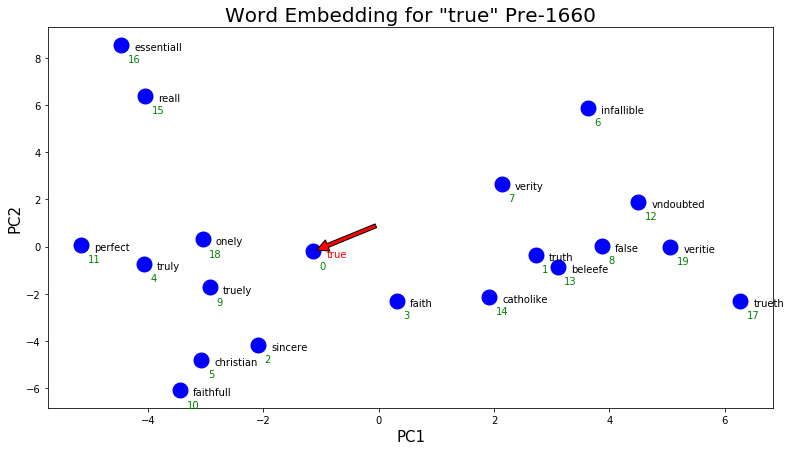

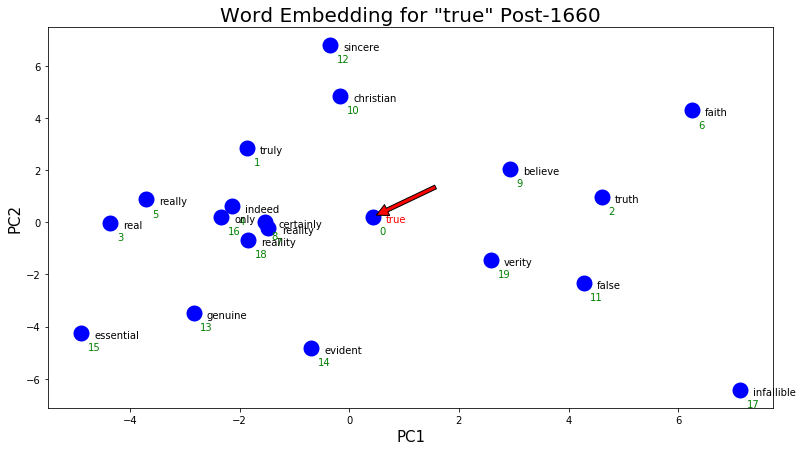

In [85]:
pre_true = !python nearest.py embeddings/sgns_v1_v2_pre1660.vec true
execute_graph_embeddings('true', 'embeddings/sgns_v1_v2_pre1660.vec', pre_true, 'Pre-1660')
post_true = !python nearest.py embeddings/sgns_v1_v2_post1660.vec true
execute_graph_embeddings('true', 'embeddings/sgns_v1_v2_post1660.vec', post_true, 'Post-1660')

As expected, "true" has slightly shifted towards more scientific senses after 1660. Examples are "evident" and "reality" that are present in the post-1660 word embeddings but not the pre-1660. More colloquial co-occuring terms were also picked up in the post-1660 word embeddings, such as "indeed", "really", "certainly" which is likely due to the popular phrases "really true", "indeed true", "certainly true". 
<br> 
We also see a weakening of the religious sense and character sense in post-1660. In the catholike/faith/christian cluster in pre-1660, catholike was dropped in post-1660. Similarly, in the sincere/faithfull cluster in pre-1660, faithfull was dropped. 

However, we see an increase in the "authentic" meaning of true with the addition of genuine to the "real"/ "essential" cluster in post-1660. 

Another interesting observations is the consistency in spelling. In the post-1660 texts, spelling became much more regularized and therefore the word embeddings picked up fewer alternative spellings. In the pre-1660, we notice many repeated words with different spellings (e.g. veritie and verity, truth and trueth). 

Now, let's take a look at some other scientific words to see if their meanings have shifted due to the Royal Society. 

| Word | Expected pre-1660 meaning| Expected post-1660 (scientific) meaning
|---------------|------------------------------------------|------------------
|right          | opposite of left, legitimate/rightful    | human rights, accurate/correct, moral/justified
|natural        | earthly, natural disposition             | humane

16.54113004139494
17.087018320832712
15.319454154235144
10.699959211006494


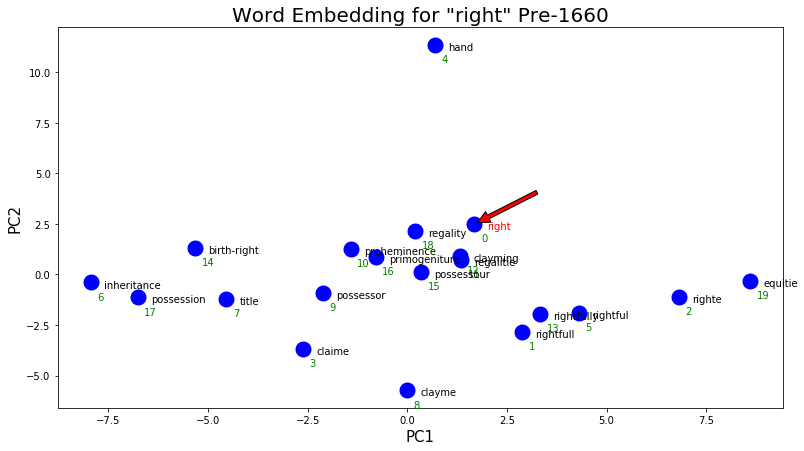

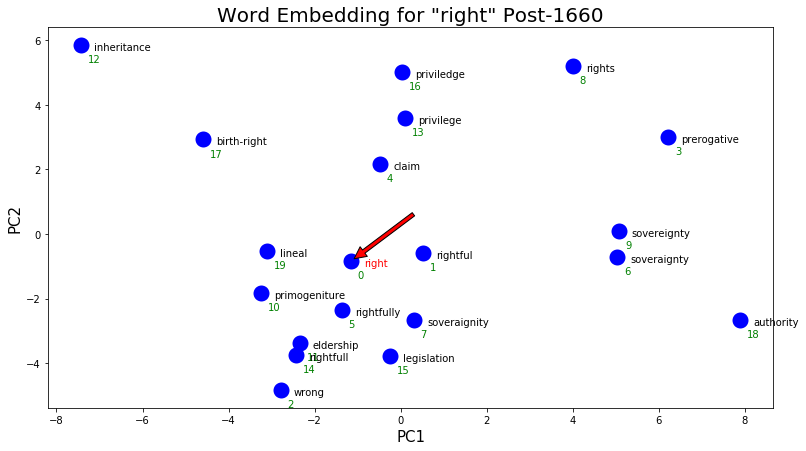

In [87]:
pre_right = !python nearest.py embeddings/sgns_v1_v2_pre1660.vec right
execute_graph_embeddings('right', 'embeddings/sgns_v1_v2_pre1660.vec', pre_right, 'Pre-1660')
post_right = !python nearest.py embeddings/sgns_v1_v2_post1660.vec right
execute_graph_embeddings('right', 'embeddings/sgns_v1_v2_post1660.vec', post_right, 'Post-1660')

More philosophical senses of "right" were picked up post-1660. Some examples are the new clusters "legislation"/"rightfull"/"wrong" as well as the cluster "privilege"/"rights"! 

['natural', 'supernatural', 'naturall', 'innate', 'adventitious', 'internal', 'nature', 'vegetative', 'human', 'aptitude', 'intrinsecal', 'temperament', 'accidental', 'implanted', 'physical', 'microcosmicall', 'intellectual', 'vegetable', 'sensation', 'formative']
11.320082642044111
9.45423138764749
['natural', 'nature', 'naturall', 'inbred', 'innate', 'moral', 'humane', 'rational', 'naturally', 'human', 'instincts', 'adventitious', 'supernatural', 'connatural', 'intellectual', 'propensions', 'consentaneous', 'corporeal', 'repugnance', 'morall']
9.931324555436948
11.840064720888883


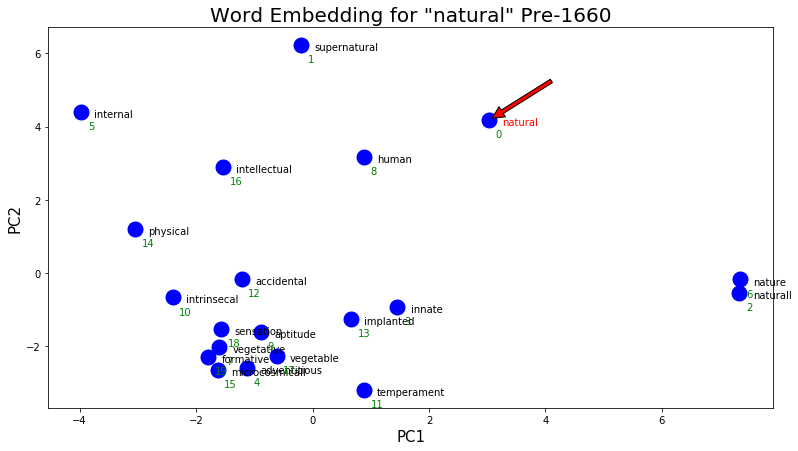

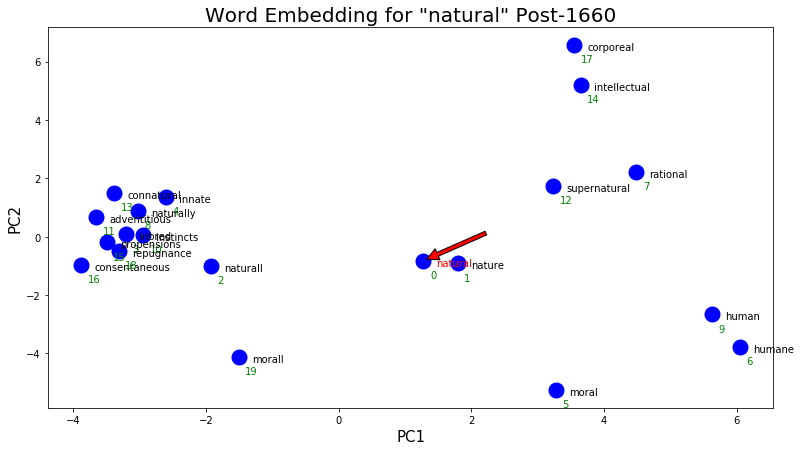

In [10]:
pre_natural = !python nearest.py embeddings/sgns_v1_v2_pre1660.vec natural
print(clean_output(pre_natural)) # Print due to some crowded text in the graph
execute_graph_embeddings('natural', 'embeddings/sgns_v1_v2_pre1660.vec', pre_natural, 'Pre-1660')
post_natural = !python nearest.py embeddings/sgns_v1_v2_post1660.vec natural
print(clean_output(post_natural))
execute_graph_embeddings('natural', 'embeddings/sgns_v1_v2_post1660.vec', post_natural, 'Post-1660')

As hoped, some more philosophical senses of "natural" appeared post-1660! Some examples are "moral"/"morall"/"humane"/"rational". 

## Change in Language Over Time using EEBO
Even within the Early Modern English time period, English may not have been stable. There may specific years or decades during this period in which the English language has changed more than usual due to important historic events (such as the formation of the British Royal Society). In which decades do we see the change in the English language accelerate (or decelerate) compared to the previous decade? 

For each 10 year period in EEBO (1474-1700), we will calculate the top 100 most common words and find the similarity between the previous period. Similarity between two consecutive time periods is measured by the number of overlapping words in the top 100 most common words. This work builds upon and references [ Grant Storey and David Mimno's Like Two Pis in a Pod: Author Similarity Across Time in the Ancient Greek Corpus](https://culturalanalytics.org/article/13680-like-two-pis-in-a-pod-author-similarity-across-time-in-the-ancient-greek-corpus).

In [91]:
# Parse in all filenames and years into a tuple list, then sort by year. 
date_tuples = []
for file in glob('date_txt/all/*.txt'):
    with open(file, 'r') as reader:
        year = int(reader.readline().strip())
        f_basename = Path(file).stem
        date_tuples.append((f_basename, year))

There are some texts outside of our date range so we will be filtering them out by strictly limiting our time period to 1470-1710. 

In [92]:
date_tuples.sort(key=lambda pair:pair[1])
print(f'The 10 earliest texts and dates are: \n{date_tuples[0:10]}\n')
print(f'The 10 latest texts and dates are: \n{date_tuples[-10:]}')

The 10 earliest texts and dates are: 
[('B01696', 16), ('B02239', 16), ('A89204', 169), ('A05232', 1473), ('A18343', 1474), ('A18231', 1476), ('A06567', 1476), ('A16385', 1477), ('A18230', 1477), ('A18294', 1477)]

The 10 latest texts and dates are: 
[('A52339', 1709), ('A46610', 1710), ('A52980', 1711), ('A57093', 1714), ('B03369', 1715), ('A67608', 1715), ('A44500', 1717), ('A42246', 1720), ('A11759', 1800), ('A57257', 1818)]


In [108]:
# Estimated run time is 10 minutes
# Find the top 100 words for each time period from 1470 to 1710. 
# The length of a time period is set by INCREMENT. 
time_period = 1470
curr_file = 0
skipped = 0
INCREMENT = 10
stop_words = stopwords.words('english') + ['thy']
most_common_dict = dict() # key is start of time period, value is 100 most common words
for start_period in range(1470, 1710, INCREMENT):
    time_period_counter = Counter() # Counter of word frequencies for this time period
    print(f'Starting period {start_period}')
    while date_tuples[curr_file][1] < start_period + INCREMENT:
        # Find the corresponding punctuated text file 
        basename = date_tuples[curr_file][0]
        filepath = os.path.join('no_punct', basename+'.headed.txt')
        if os.path.isfile(filepath):
            with open(filepath, 'r') as reader: # Read file, tokenize, and update Counter
                for line in reader: 
                    line_tokens = [token for token in line.split(' ') if len(token) > 2 and token not in stop_words]
                    time_period_counter.update(line_tokens)
        else:
            skipped += 1
        curr_file += 1
    most_common_dict[start_period] = time_period_counter.most_common(100)
print(f'Skipped: {skipped}')

Starting period 1470
Starting period 1480
Starting period 1490
Starting period 1500
Starting period 1510
Starting period 1520
Starting period 1530
Starting period 1540
Starting period 1550
Starting period 1560
Starting period 1570
Starting period 1580
Starting period 1590
Starting period 1600
Starting period 1610
Starting period 1620
Starting period 1630
Starting period 1640
Starting period 1650
Starting period 1660
Starting period 1670
Starting period 1680
Starting period 1690
Starting period 1700
Skipped: 16979


In [ ]:
pickle.dump(most_common_dict, open('most_common_dict.pkl', 'wb'))

In [ ]:
most_common_dict = pickle.load(open('most_common_dict.pkl', 'rb'))

Similarity between 1470-1480 and 1480-1490: 41%

Top 15 words in 1470: ['thou', 'thinges', 'thing', 'whiche', 'hem', 'good', 'ben', 'men', 'may', 'whan', 'haue', 'hath', 'right', 'god', 'certes', 'yet', 'hit', 'then̄e', 'thilke', 'man']


Similarity between 1480-1490 and 1490-1500: 53%

Top 15 words in 1480: ['hym', 'est', 'thenne', 'haue', 'per', 'grete', 'quod', 'god', 'whan', 'sayd', 'whiche', 'said', 'thou', 'man', 'alle', 'made', 'men', 'shold', 'kynge', 'saynt']


Similarity between 1490-1500 and 1500-1510: 60%

Top 15 words in 1490: ['god', 'haue', 'man', 'men', 'hym', 'ād', 'grete', 'also', 'thou', 'shall', 'ther', 'nat', 'kyng', 'may', 'hys', 'whiche', 'made', 'hem', 'vnto', 'therfore']


Similarity between 1500-1510 and 1510-1520: 61%

Top 15 words in 1500: ['whiche', 'haue', 'hym', 'vnto', 'god', 'thou', 'per', 'may', 'shall', 'grete', 'sayd', 'man', 'holy', 'good', 'also', 'loue', 'hath', 'suche', 'whan', 'tyme']


Similarity between 1510-1520 and 1520-1530: 52%

Top 15 wo

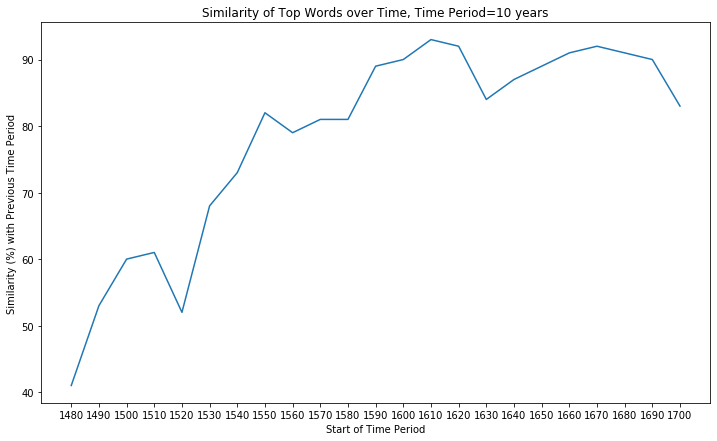

In [113]:
# Find the number of overlapping common words between consecutive time periods
prev_words = [pair[0] for pair in most_common_dict[1470]]
dates = [x for x in range(1470+INCREMENT, 1710, INCREMENT)]
similarities = []
for year in range(1470+INCREMENT, 1710, INCREMENT): 
    curr_words = [pair[0] for pair in most_common_dict[year]]
    similarity = set(prev_words).intersection(set(curr_words))
    print(f"Similarity between {year-INCREMENT}-{year} and {year}-{year+INCREMENT}: {len(similarity)}%\n")
    print(f"Top 15 words in {year-INCREMENT}: {prev_words[:20]}\n\n")
    similarities.append(len(similarity))
    prev_words = curr_words
    
# Graph the number of overlapping common words (similarity)
plt.figure(figsize=(12,7))
plt.plot(dates,similarities)
plt.xticks(np.arange(min(dates), max(dates)+INCREMENT, INCREMENT))
plt.title(f'Similarity of Top Words over Time, Time Period={INCREMENT} years')
plt.xlabel('Start of Time Period')
plt.ylabel('Similarity (%) with Previous Time Period')
plt.show()
    

English was rapidly stabilizing between 1480 and 1550! After 1550, English was slow-changing, with 80-90% overlap with the previous decade. 1530s-1550s seems to be two pivotal decades, jumping roughly 30% in similarity as opposed to the 1520s. One reason may be the official publications of central Christian texts and service books that are used widely across all churches during this period, including the [the Great Bible](https://en.wikipedia.org/wiki/Great_Bible) in 1539 and [Book of Common Prayer](https://en.wikipedia.org/wiki/Book_of_Common_Prayer) in 1549, which helped standardize English and popularize certain words, and thereby giving rise to the stabilization of English in the 1530s-1550s. 


The popularity of these religious texts is further shown by the frequency of the mention of "god". From 1540s onward to the end of the Early Modern English era, "god" has consistently been the top first or second word in the top 15 words of each decade.

## Comparison to Late Modern English

Now let's compare EEBO with books and word embeddings in 1890 and 1990 using the 'All English' data and vectors from the [HistWords project](https://nlp.stanford.edu/projects/histwords/) by William L. Hamilton, Jure Leskovec, and Dan Jurafsky. The 'All English' data from HistWords is sourced from [Google Books N-grams](https://storage.googleapis.com/books/ngrams/books/datasetsv2.html). Let's see how these word meanings have changed 2 centuries later!

### 1890 English Corpus

In [4]:
with open('sgns/1890-vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [5]:
modern_embeddings = np.load('sgns/1890-w.npy')

[ 1.  1.  1. ... nan nan nan]
1.000	true
0.448	truth
0.389	genuine
0.385	false
0.376	ideal
0.365	nevertheless
0.359	essence
0.356	axiomatic
0.352	believed
0.349	demonstrably
0.348	meaning
0.347	reality
0.344	untrue
0.341	sincere
0.340	truer
0.340	faith
0.334	statement
0.332	real
0.331	correct
0.323	because
0.9873966504203295
0.85651568023696


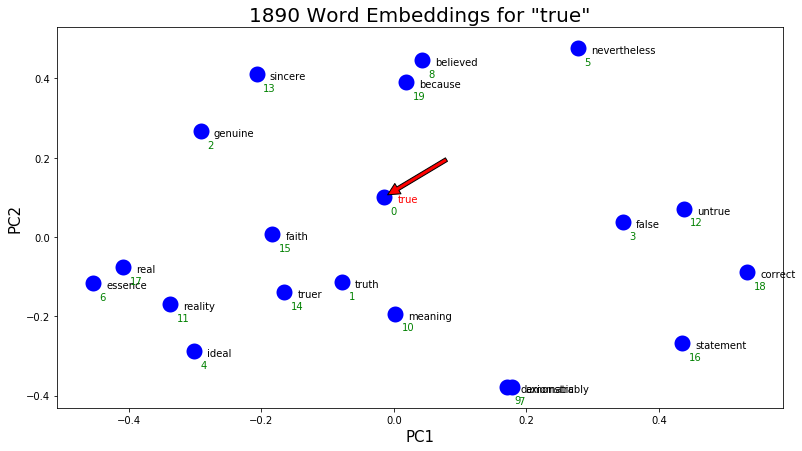

In [13]:
output_true = find_nearest('true', modern_embeddings, vocab)
output_true = clean_output(output_true)
true_dict = {w:modern_embeddings[vocab.index(w)] for w in output_true}
visualize_embeddings(output_true, 'true', true_dict, title='1890 Word Embeddings for "true"')

It is exciting to see that the meaning of 'true' has shifted a lot from Early Modern English to Late Modern English in the 1890s! 
Some things to note for 'true' in 1890:


1. The religious co-occurrence has mostly disappeared (as expected)! 'Faith' is the only word left and is ranked 15 out of 20.


2. Many, many new definitions of 'true' have emerged. This could in part be due to the greater diversity of modern day fiction texts and topics. 'True' today could mean 'real' (bottom left cluster) or 'truth' (middle bottom cluster) or correct/false (bottom right cluster) or genuine/sincere (top left cluster). 

[ 1.  1.  1. ... nan nan nan]
1.000	awe
0.536	reverence
0.514	terror
0.514	veneration
0.479	horror
0.460	dread
0.453	inspire
0.445	wonder
0.436	amazement
0.431	admiration
0.416	dismay
0.414	astonishment
0.408	superstitious
0.394	beholder
0.392	sadness
0.391	solemnity
0.381	inspiring
0.379	awful
0.375	speechless
0.375	inspired
0.981034549167014
1.085911536777402


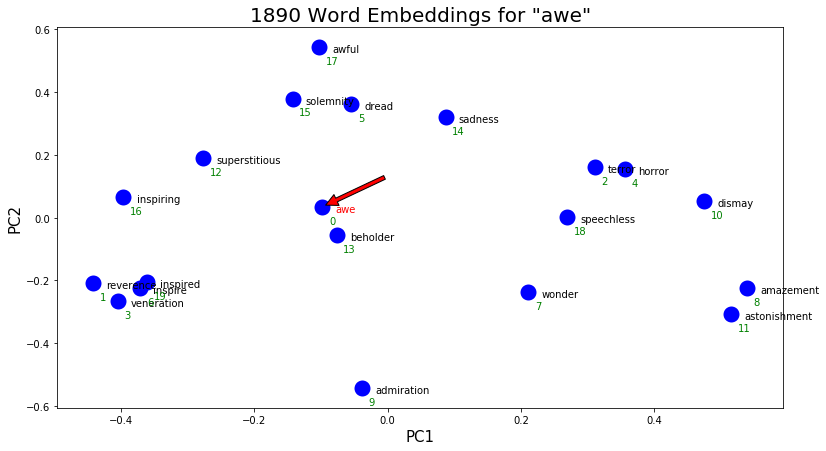

In [14]:
output_awe = find_nearest('awe', modern_embeddings, vocab)
output_awe = clean_output(output_awe)
awe_dict = {w:modern_embeddings[vocab.index(w)] for w in output_awe}
visualize_embeddings(output_awe, 'awe', awe_dict, title='1890 Word Embeddings for "awe"')

Similarly, 'awe' has also become overloaded with meaning in Late Modern English.
For example, some synonyms are amazement/astonishment in bottom right, reverence/inspired in the bottom left, sadness/awful in top middle, and terror/horror in the middle right. 

### 1990 English History Corpus

The 1990 English word embeddings are generally very similar to the 1890 word embeddings. Can you find all the different clusters of meaning for 'true' and 'awe'? 

In [77]:
with open('sgns/1990-vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
modern_embeddings = np.load('sgns/1990-w.npy')

[ 1.  1.  1. ... nan nan nan]
1.000	true
0.448	truth
0.389	genuine
0.385	false
0.376	ideal
0.365	nevertheless
0.359	essence
0.356	axiomatic
0.352	believed
0.349	demonstrably
0.348	meaning
0.347	reality
0.344	untrue
0.341	sincere
0.340	truer
0.340	faith
0.334	statement
0.332	real
0.331	correct
0.323	because
0.9873966504203289
0.856515680236961


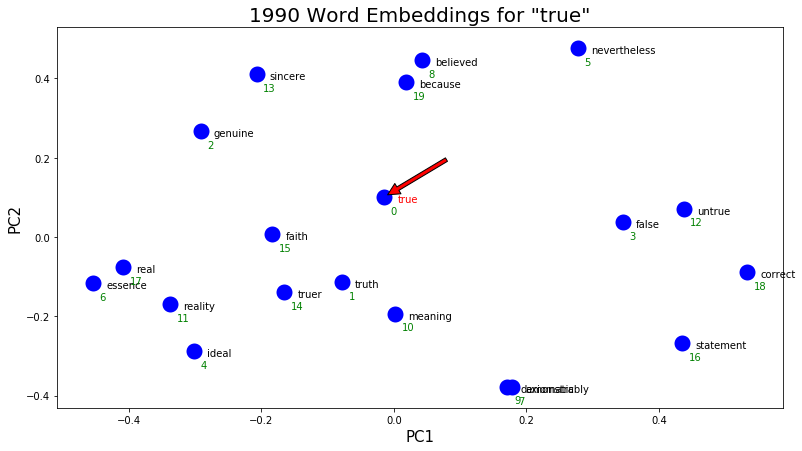

In [16]:
output_true = find_nearest('true', modern_embeddings, vocab)
output_true = clean_output(output_true)
true_dict = {w:modern_embeddings[vocab.index(w)] for w in output_true}
visualize_embeddings(output_true, 'true', true_dict, title='1990 Word Embeddings for "true"')

[ 1.  1.  1. ... nan nan nan]
1.000	awe
0.536	reverence
0.514	terror
0.514	veneration
0.479	horror
0.460	dread
0.453	inspire
0.445	wonder
0.436	amazement
0.431	admiration
0.416	dismay
0.414	astonishment
0.408	superstitious
0.394	beholder
0.392	sadness
0.391	solemnity
0.381	inspiring
0.379	awful
0.375	speechless
0.375	inspired
0.9810345491670139
1.0859115367774033


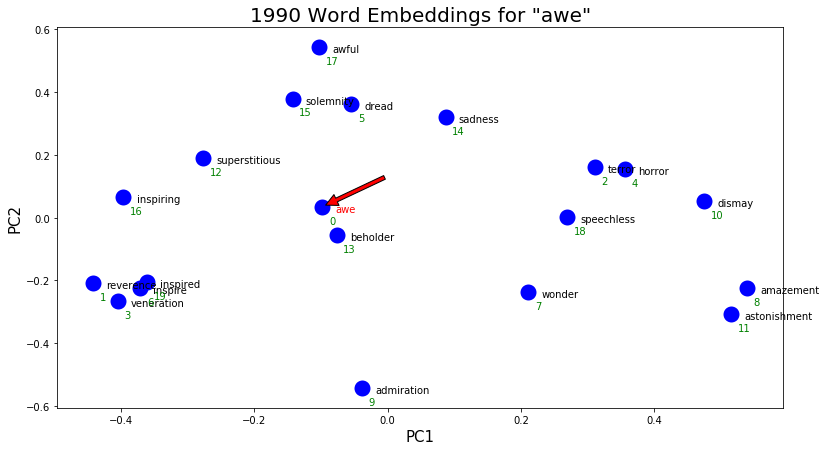

In [17]:
output_awe = find_nearest('awe', modern_embeddings, vocab)
output_awe = clean_output(output_awe)
awe_dict = {w:modern_embeddings[vocab.index(w)] for w in output_awe}
visualize_embeddings(output_awe, 'awe', awe_dict, title='1990 Word Embeddings for "awe"')

## Future Work

EEBO data covers the 1470-1700 period and HistWords data covers 1800 and beyond, so we did not have any 1700s data in this project. Potential future work may consist of looking at word embeddings as well as the acceleration of change in word usage from books in the 18th century to bridge century gap and create a more holistic view of the evolution of English words. In addition, it would be interesting to see how stable Late Modern English is. Because the HistWords data only included the words and not the frequencies, we did not have any data to graph the acceleration of change. In the future, word frequencies can be directly extracted from Google Books N-grams to plot change in top words between decades.  

## Conclusion

English was a rapidly evolving language in the Early Modern English era, particularly between 1470 and 1550. Many key events in the UK including the publication of popular religious texts and the formation of the Royal Society had major influence over the shifts in word meanings and usage. Throughout the end of the Early Modern era and Late Modern era, changes in the English language has been slow, although in general, words have picked up many more senses by the Late Modern English period and have become overloaded with meaning. 
Words that had a religious connotation and usage in the Early Modern English period like "true"
saw the religious meaning mostly disappear by 1890, likely due to the decline in the popularity of religion and fewer texts written about religion. 